Summary of my results:

model            | train_loss | valid_loss | seq2seq_acc | bleu
-------------------|----------|----------|----------|----------
seq2seq            | 3.355085 | 4.272877 | 0.382089 | 0.291899
\+ teacher forcing | 3.154585 |	4.022432 | 0.407792 | 0.310715
\+ attention       | 1.452292 | 3.420485 | 0.498205 | 0.413232
transformer        | 1.913152 | 2.349686 | 0.781749 | 0.612880

# Seq2Seq Translation with Attention

Attention is a technique that uses the output of our encoder: instead of discarding it entirely, we use it with our hidden state to pay attention to specific words in the input sentence for the predictions in the output sentence. Specifically, we compute attention weights, then add to the input of the decoder the linear combination of the output of the encoder, with those attention weights.

A nice illustration of attention comes from [this blog post](http://jalammar.github.io/illustrated-transformer/) by Jay Alammar (visualization originally from [Tensor2Tensor notebook](https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb)):

<img src="images/alammar-attention.png" alt="attention" style="width: 60%"/>

A second things that might help is to use a bidirectional model for the encoder. We set the `bidrectional` parameter to `True` for our GRU encoder, and double the number of inputs to the linear output layer of the encoder.

Also, we now need to set our hidden state:

```
hid = hid.view(2,self.n_layers, bs, self.n_hid).permute(1,2,0,3).contiguous()
hid = self.out_enc(self.hid_dp(hid).view(self.n_layers, bs, 2*self.n_hid))
```

### Code to re-run from start

In [1]:
from fastai.text import *

In [2]:
path = Config().data_path()

In [3]:
path = Config().data_path()/'giga-fren'

In [4]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False) -> Tuple[LongTensor, LongTensor]:
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0])],res_y[i,:len(s[1])] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [10]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [11]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [12]:
data = load_data(path)

In [13]:
model_path = Config().model_path()

In [14]:
emb_enc = torch.load(model_path/'fr_emb.pth')
emb_dec = torch.load(model_path/'en_emb.pth')

In [15]:
def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

In [16]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

In [17]:
class NGram():
    def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
    def __eq__(self, other):
        if len(self.ngram) != len(other.ngram): return False
        return np.all(np.array(self.ngram) == np.array(other.ngram))
    def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))

In [18]:
def get_grams(x, n, max_n=5000):
    return x if n==1 else [NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]

In [19]:
def get_correct_ngrams(pred, targ, n, max_n=5000):
    pred_grams,targ_grams = get_grams(pred, n, max_n=max_n),get_grams(targ, n, max_n=max_n)
    pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
    return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)

In [20]:
def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [21]:
class CorpusBLEU(Callback):
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz
        self.name = 'bleu'
    
    def on_epoch_begin(self, **kwargs):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        last_output = last_output.argmax(dim=-1)
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
    
    def on_epoch_end(self, last_metrics, **kwargs):
        precs = [c/t for c,t in zip(self.corrects,self.counts)]
        len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
        bleu = len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)
        return add_metrics(last_metrics, bleu)

In [136]:
class TeacherForcing(LearnerCallback):
    def __init__(self, learn, end_epoch):
        super().__init__(learn)
        self.end_epoch = end_epoch
    
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if train: return {'last_input': [last_input, last_target]}
    
    def on_epoch_begin(self, epoch, **kwargs):
        self.learn.model.pr_force = 1 - epoch/self.end_epoch

### Implementing attention

In [137]:
class Seq2SeqRNN_attn(nn.Module):
    def __init__(self, emb_enc, emb_dec, nh, out_sl, nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl,self.pr_force = nl,nh,out_sl,1
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.emb_enc,self.emb_dec = emb_enc,emb_dec
        self.emb_sz_enc,self.emb_sz_dec = emb_enc.embedding_dim,emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.emb_sz_enc, nh, num_layers=nl, dropout=0.25, 
                              batch_first=True, bidirectional=True)
        self.out_enc = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        
        self.gru_dec = nn.GRU(self.emb_sz_dec + 2*nh, self.emb_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.emb_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
        self.enc_att = nn.Linear(2*nh, self.emb_sz_dec, bias=False)
        self.hid_att = nn.Linear(self.emb_sz_dec, self.emb_sz_dec)
        self.V =  self.init_param(self.emb_sz_dec)
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, hid = self.gru_enc(emb, 2*h)
        
        pre_hid = hid.view(2, self.nl, bs, self.nh).permute(1,2,0,3).contiguous()
        pre_hid = pre_hid.view(self.nl, bs, 2*self.nh)
        hid = self.out_enc(pre_hid)
        return hid,enc_out
    
    def decoder(self, dec_inp, hid, enc_att, enc_out):
        hid_att = self.hid_att(hid[-1])
        # we have put enc_out and hid through linear layers
        u = torch.tanh(enc_att + hid_att[:,None])
        # we want to learn the importance of each time step
        attn_wgts = F.softmax(u @ self.V, 1)
        # weighted average of enc_out (which is the output at every time step)
        ctx = (attn_wgts[...,None] * enc_out).sum(1)
        emb = self.emb_dec(dec_inp)
        # concatenate decoder embedding with context (we could have just
        # used the hidden state that came out of the decoder, if we weren't
        # using attention)
        outp, hid = self.gru_dec(torch.cat([emb, ctx], 1)[:,None], hid)
        outp = self.out(self.out_drop(outp[:,0]))
        return hid, outp
        
    def show(self, nm,v):
        if False: print(f"{nm}={v[nm].shape}")
        
    def forward(self, inp, targ=None):
        bs, sl = inp.size()
        hid,enc_out = self.encoder(bs, inp)
#        self.show("hid",vars())
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        enc_att = self.enc_att(enc_out)
        
        res = []
        for i in range(self.out_sl):
            hid, outp = self.decoder(dec_inp, hid, enc_att, enc_out)
            res.append(outp)
            dec_inp = outp.max(1)[1]
            if (dec_inp==self.pad_idx).all(): break
            if (targ is not None) and (random.random()<self.pr_force):
                if i>=targ.shape[1]: continue
                dec_inp = targ[:,i]
        return torch.stack(res, dim=1)

    def initHidden(self, bs): return one_param(self).new_zeros(2*self.nl, bs, self.nh)
    def init_param(self, *sz): return nn.Parameter(torch.randn(sz)/math.sqrt(sz[0]))

```
hid=torch.Size([2, 64, 300])
dec_inp=torch.Size([64])
enc_att=torch.Size([64, 30, 300])
hid_att=torch.Size([64, 300])
u=torch.Size([64, 30, 300])
attn_wgts=torch.Size([64, 30])
enc_out=torch.Size([64, 30, 512])
ctx=torch.Size([64, 512])
emb=torch.Size([64, 300])
```

In [142]:
model = Seq2SeqRNN_attn(emb_enc, emb_dec, 256, 30)
learn = Learner(data, model, loss_func=seq2seq_loss, metrics=[seq2seq_acc, CorpusBLEU(len(data.y.vocab.itos))],
                callback_fns=partial(TeacherForcing, end_epoch=30))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


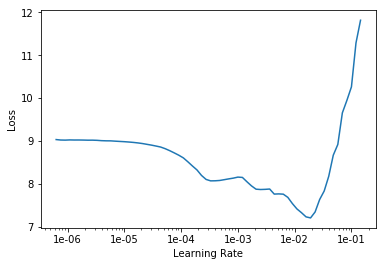

In [55]:
learn.lr_find()
learn.recorder.plot()

In [141]:
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,seq2seq_acc,bleu,time
0,1.887606,3.718430,0.556508,0.341307,01:25
1,1.506591,3.122954,0.551054,0.402871,01:36
2,1.548055,3.860026,0.473495,0.410226,01:33
3,1.735435,3.202152,0.529949,0.441509,01:36
4,1.808599,3.711476,0.472057,0.408111,01:32
5,1.891013,3.141925,0.523613,0.437650,01:34
6,1.952281,3.402686,0.485307,0.413826,01:29
7,2.096382,3.790361,0.442190,0.379218,01:28
8,1.994412,3.421550,0.474625,0.396157,01:29
9,2.207710,3.459248,0.473342,0.392821,01:26


In [146]:
inputs, targets, outputs = get_predictions(learn)

In [147]:
inputs[700], targets[700], outputs[700]

(Text xxbos qui a le pouvoir de modifier le règlement sur les poids et mesures et le règlement sur l'inspection de l'électricité et du gaz ?,
 Text xxbos who has the authority to change the electricity and gas inspection regulations and the weights and measures regulations ?,
 Text xxbos what do we regulations and and regulations ? ?)

In [148]:
inputs[701], targets[701], outputs[701]

(Text xxbos ´ ` ou sont xxunk leurs grandes convictions en ce qui a trait a la ` ` ´ transparence et a la responsabilite ?,
 Text xxbos what happened to their great xxunk about transparency and accountability ?,
 Text xxbos what are the and and and and and and and and and to to ? ?)

In [149]:
inputs[4002], targets[4002], outputs[4002]

(Text xxbos quelles ressources votre communauté possède - t - elle qui favoriseraient la guérison ?,
 Text xxbos what resources exist in your community that would promote recovery ?,
 Text xxbos what resources would your community community community community community community ?)